## Elementos finitos linear 1D

## Montar a matrix de massa

In [163]:
using Jacobi

## Funções

In [164]:
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2

remap (generic function with 1 method)

In [165]:
function ψj(p,E,Q)
    if(p == 1)
     return  (1-E)/2
        elseif(p == 2)
     return  (1+E)/2
    else
     return  (1-E)*(1+E)/4 .* jacobi(E, p-3, 1, 1)
    end
end 

ψj (generic function with 1 method)

In [166]:
function  ϕ_matrix(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = zglj(Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix (generic function with 1 method)

In [167]:
function  ϕ_matrix_interp(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = linspace(-1,1,Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix_interp (generic function with 1 method)

In [168]:
function Me_matrix(ϕ,w,M,Q,a,b)
    L = zeros(M,M)
    jac = (b-a)/2
    for i in 1:M
        for j in 1:M
           m= 0.0
            for q in 1:Q
                m = m + ϕ[q,i]*ϕ[q,j]*w[q]*jac
            end
            L[i,j] = m
        end
    end
    return L
end

Me_matrix (generic function with 1 method)

### $ϕ$ e  matriz de massa

In [169]:
Nel = 80
I = 4
nb = Nel + 1
ni = (I-2)
Q = I+2

#indices locais
ib = collect(1:2)
ii = collect(3:I)

#limites
a = -1; 
b = 1;

z = zglj(Q)
w = wglj(z)
ϕ = ϕ_matrix(ψj,Q,I);
xn = [linspace(a,b,Nel+1);];
X = zeros(Q,Nel)
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2
for e in 1:Nel
    X[:,e] = [remap(x,xn[e],xn[e+1]) for x in z]
end
X

6x80 Array{Float64,2}:
 -1.0       -0.975     -0.95      -0.925     …  0.925     0.95      0.975   
 -0.997063  -0.972063  -0.947063  -0.922063     0.927937  0.952937  0.977937
 -0.991065  -0.966065  -0.941065  -0.916065     0.933935  0.958935  0.983935
 -0.983935  -0.958935  -0.933935  -0.908935     0.941065  0.966065  0.991065
 -0.977937  -0.952937  -0.927937  -0.902937     0.947063  0.972063  0.997063
 -0.975     -0.95      -0.925     -0.9       …  0.95      0.975     1.0     

In [170]:

dof_map = zeros(Int, 2, Nel)
for i = 1:Nel
    dof_map[1,i] = i
    dof_map[2,i] = i+1
end
dof_map

2x80 Array{Int64,2}:
 1  2  3  4  5  6  7  8   9  10  11  …  72  73  74  75  76  77  78  79  80
 2  3  4  5  6  7  8  9  10  11  12     73  74  75  76  77  78  79  80  81

In [171]:

using Base.LinAlg.BLAS.gemm!
using Base.LinAlg.BLAS.gemv!
using Base.LinAlg.LAPACK.potrf!
using Base.LinAlg.LAPACK.potrs!

### $ A_{bb}^* = (A_{bb} - A_{bi} A_{ii}^{-1} A_{ib})  $

In [172]:
dp  = zeros(Nel +1)
dl  = zeros(Nel)
M = Vector{Array{Float64,2}}(Nel)
Mii = Vector{Array{Float64,2}}(Nel)
for e in 1:Nel
    Me = Me_matrix(ϕ, w, I, Q, xn[e], xn[e+1]) ;


    
    Mbb = Me[ib,ib]
    Mbi = Me[ib,ii]
    Mib = Me[ii,ib]
    Mii[e] = Me[ii,ii]
    
    potrf!('L',Mii[e]); #Mii^-1
    M[e] = copy(Mib)
    potrs!('L',Mii[e],M[e]) # M = Mii^-1 * Mbi
    gemm!('T', 'N', -1.0, M[e], Mib, 1.0, Mbb) # Mbb = -1*M*Mib + Mbb
    
    for i in 1:2
        ig = dof_map[i,e]
        for j in 1:2
            jg = dof_map[j,e]
            if jg == ig #principal
                dp[jg] += Mbb[i,j]
            end
            if jg == ig + 1 && jg > 1#low
              dl[jg-1] += Mbb[i,j] 
            end
        end
    end
end
Abb = SymTridiagonal(dp,dl) 
#potrf!('L',Abb);
Abb

81x81 SymTridiagonal{Float64}:
 0.00166667   0.000416667  0.0          …  0.0          0.0        
 0.000416667  0.00333333   0.000416667     0.0          0.0        
 0.0          0.000416667  0.00333333      0.0          0.0        
 0.0          0.0          0.000416667     0.0          0.0        
 0.0          0.0          0.0             0.0          0.0        
 0.0          0.0          0.0          …  0.0          0.0        
 0.0          0.0          0.0             0.0          0.0        
 0.0          0.0          0.0             0.0          0.0        
 0.0          0.0          0.0             0.0          0.0        
 0.0          0.0          0.0             0.0          0.0        
 0.0          0.0          0.0          …  0.0          0.0        
 0.0          0.0          0.0             0.0          0.0        
 0.0          0.0          0.0             0.0          0.0        
 ⋮                                      ⋱               ⋮          
 0.0          0.0

In [173]:
fact = ldltfact!(Abb)

Base.LinAlg.LDLt{Float64,SymTridiagonal{Float64}}(81x81 SymTridiagonal{Float64}:
 0.00166667  0.25        0.0         …  0.0         0.0         0.0       
 0.25        0.00322917  0.129032       0.0         0.0         0.0       
 0.0         0.129032    0.00327957     0.0         0.0         0.0       
 0.0         0.0         0.127049       0.0         0.0         0.0       
 0.0         0.0         0.0            0.0         0.0         0.0       
 0.0         0.0         0.0         …  0.0         0.0         0.0       
 0.0         0.0         0.0            0.0         0.0         0.0       
 0.0         0.0         0.0            0.0         0.0         0.0       
 0.0         0.0         0.0            0.0         0.0         0.0       
 0.0         0.0         0.0            0.0         0.0         0.0       
 0.0         0.0         0.0         …  0.0         0.0         0.0       
 0.0         0.0         0.0            0.0         0.0         0.0       
 0.0         0.0   

## RHS

In [174]:
fun(x) = cos(2*pi*x)
#calcula F
Fe = zeros(I,Nel)
for e = 1:Nel
    jac = (xn[e+1] - xn[e] )/2
    for i in 1:I
        temp = 0.0
        for q in 1:Q
            temp += fun(X[q,e])* ϕ[q,i] * w[q] * jac
        end
        Fe[i,e] = temp
    end
end
Fe

4x80 Array{Float64,2}:
  0.0124743    0.0122185    0.0116618   …  0.0114115   0.0120658   0.012423  
  0.012423     0.0120658    0.0114115      0.0116618   0.0122185   0.0124743 
  0.00415126   0.00404904   0.00384712     0.00384712  0.00404904  0.00415126
 -1.02657e-5  -3.05445e-5  -5.00711e-5     5.00711e-5  3.05445e-5  1.02657e-5

### $f_b^* =f_b - A_{bi} A_{ii}^{-1} f_i$

In [175]:
Fb = zeros(nb)

for e in 1:Nel
    fe  = Fe[:,e]
    fb  = fe[ib]
    fi  = fe[ii]
    gemv!('T',-1.0,M[e],fi, 1.0, fb) #fbb = -1*M^T*fi + fb

    for i in 1:2
        ig = dof_map[i,e]
        Fb[ig] += fb[i]
    end

end
Fb

81-element Array{Float64,1}:
  0.0020782  
  0.00410523 
  0.00395298 
  0.00370338 
  0.0033626  
  0.00293902 
  0.00244307 
  0.00188697 
  0.0012844  
  0.000650205
 -6.50521e-19
 -0.000650205
 -0.0012844  
  ⋮          
 -0.000650205
 -6.50521e-19
  0.000650205
  0.0012844  
  0.00188697 
  0.00244307 
  0.00293902 
  0.0033626  
  0.00370338 
  0.00395298 
  0.00410523 
  0.0020782  

# Solve   $A^*_{bb}\ u_b =\ f^*_b$

In [176]:
Ue = zeros(I,Nel)

#potrs!('L',Abb,Fb)
Ub = fact\Fb


81-element Array{Float64,1}:
  1.0        
  0.987688   
  0.951056   
  0.891006   
  0.809017   
  0.707107   
  0.587785   
  0.45399    
  0.309017   
  0.156434   
 -1.42247e-16
 -0.156434   
 -0.309017   
  ⋮          
 -0.156434   
 -1.76942e-16
  0.156434   
  0.309017   
  0.45399    
  0.587785   
  0.707107   
  0.809017   
  0.891006   
  0.951056   
  0.987688   
  1.0        

### $u_i = A_{ii}^{-1}f_i - A_{ii}^{-1} A_{bi}^t u_b$

In [177]:
U = zeros(I,Nel)
for e in 1:Nel
    ub  = Ub[vec(dof_map[:,e])]
    fe  = Fe[:,e]
    fi  = fe[ii]

    potrs!('L',Mii[e],fi)
    gemv!('N',-1.0,M[e],ub,1.0,fi) #fi = -1*M*ub + fi
    
    U[ib,e]= ub
    U[ii,e] = fi
end
U

4x80 Array{Float64,2}:
  1.0         0.987688    0.951056    …  0.891006    0.951056   0.987688 
  0.987688    0.951056    0.891006       0.951056    0.987688   1.0      
  0.0122936   0.0119908   0.0113929      0.0113929   0.0119908  0.0122936
 -1.2673e-5  -3.7707e-5  -6.18126e-5     6.18126e-5  3.7707e-5  1.2673e-5

In [178]:
Uh = zeros(Q,Nel)
for e in 1:Nel
    Uh[:,e] = ϕ*U[:,e]
end
Uh

6x80 Array{Float64,2}:
 1.0       0.987688  0.951056  0.891006  …  0.891006  0.951056  0.987688
 0.99983   0.984634  0.945193  0.882478     0.899232  0.956597  0.990407
 0.998425  0.977355  0.93222   0.86413      0.915076  0.966897  0.99491 
 0.99491   0.966897  0.915076  0.840722     0.93222   0.977355  0.998425
 0.990407  0.956597  0.899232  0.819725     0.945193  0.984634  0.99983 
 0.987688  0.951056  0.891006  0.809017  …  0.951056  0.987688  1.0     

In [179]:
using PyPlot

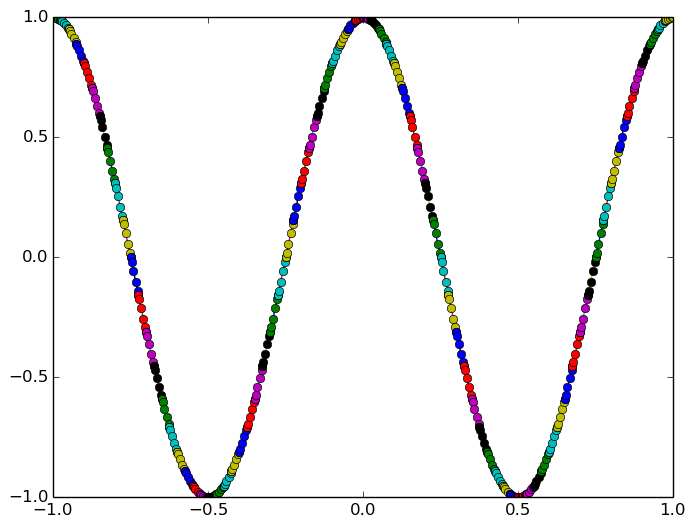

In [180]:
Ue = fun(X)
erro = Uh - Ue
for e in 1:Nel
    plot(X[:,e],Uh[:,e])
    plot(X[:,e],fun(X[:,e]),"o")
#    legend()
end


In [181]:
Ndof = nb + Nel*(ni)
Ndof,maxabs(erro)

(241,3.621847660673083e-7)